# Distortion Correction

*Note*:
* DJI_0002.MOV was used to extract frames for the calibration process.
* DJI_0004.MOV was used for test frames that included the balls, easier to see the results of undistorion.

*Requirements*:
* Make sure the video from the DJI is in root directory.

In [1]:
import cv2
import os
import sys
sys.path.append('./Calib')

# Set of custom functions which manipulate the form of data before inputting to openCV functions
from calib import calib, app, utils

### First, extract frames of checkerboard

* The path the calibration video (Checkerboard moving infront of cam)
* Extracted frame output directory

In [1]:
video_dir = './DJI_0002.MOV'
frame_output_dir = './Extracted_Frames'

The following extracts individual frames from the recorded video.
* Line 8 can be edited to choose how often a frame is saved. It can be every frame or every desired **n** frames.

In [24]:
# Opens the Video file
cap= cv2.VideoCapture(video_dir)
i=0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    if(not(i%30)): # Save every 30 frames
        cv2.imwrite(os.path.join(frame_output_dir, f'img{int(i):05}.jpg'),frame)
        i+=1
    else:
        i+=1

cap.release()
cv2.destroyAllWindows()
print("Extraction Complete")

Extraction Complete


### Find Checkerboard points

#### Main parameters:
* camera resolution
* board edge length 
* board shape and
* frames with checkerboard in view

See *distortion requirements* google doc for explanation of *board edge length* and *board shape* variables.

#### Code Explanation
1. Variables passed to utility functions that preprocess data into a desired format for final openCV functions which identify and locate checkerboard corners.

2. The found points are stored in *points.json* file

In [3]:
# Camera & Board parameters
camera_resolution = (3840,2160) # 4K

board_edge_len = 0.0175 # 17.5mm
board_shape = (9,6) # Row by columns

# prepare the output dir
frames_fpath = frame_output_dir #os.path.join(INTRINSIC_DATA_DIR, "frames")
#if not os.path.exists(frames_fpath):
#    os.makedirs(frames_fpath)

# 'window_size' sets the size of the calibration board corner detector window size
app.extract_corners_from_images(
    img_dir=frames_fpath, 
    out_fpath= "./points.json", #os.path.join(INTRINSIC_DATA_DIR, "points.json"), 
    board_shape=board_shape, 
    board_edge_len=board_edge_len, 
    window_size=5, 
    remove_unused_images=True
)

Finding calibration board corners for images in ./Extracted_Frames
Found corners for file 0: ./Extracted_Frames\img00030.jpg
Found corners for file 1: ./Extracted_Frames\img00060.jpg
Found corners for file 2: ./Extracted_Frames\img00090.jpg
Found corners for file 3: ./Extracted_Frames\img00120.jpg
Found corners for file 4: ./Extracted_Frames\img00150.jpg
Found corners for file 5: ./Extracted_Frames\img00180.jpg
Found corners for file 6: ./Extracted_Frames\img00210.jpg
Found corners for file 7: ./Extracted_Frames\img00240.jpg
Found corners for file 8: ./Extracted_Frames\img00270.jpg
Found corners for file 9: ./Extracted_Frames\img00300.jpg
Found corners for file 10: ./Extracted_Frames\img00330.jpg
Found corners for file 11: ./Extracted_Frames\img00360.jpg
Found corners for file 12: ./Extracted_Frames\img00390.jpg
Found corners for file 13: ./Extracted_Frames\img00420.jpg
Found corners for file 14: ./Extracted_Frames\img00450.jpg
Found corners for file 15: ./Extracted_Frames\img00480.jpg

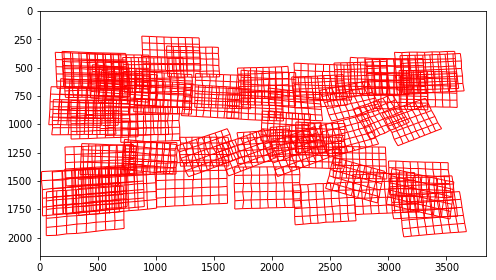

In [4]:
#Simply for illustration puposes
#Explanation: Plotting the found checkerboard points. Each rectangle is from a unique frame.
app.plot_corners("./points.json")

### Determine Intrinsic Parameters

A description of camera calibration and the relevant parameters can be found [HERE](https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html?highlight=stereoCalibrate)

In order to correct distortion we only need to determine the *intrinsic* parameters. These are internal to the camera and will remain constant no matter the viewed scene given the following is kept constant.

* Zoom of the camera lens
* Focal length

It is also suitable to assume the intrinsic parameters are the same for two identical cameras (same model). *The cameras obiviously won't be exactly the same however, any variance should be negligable*.

#### Code Explanation:
1. The camera matrix is stored in the variable K, this contains thing such as focal length. D stores the distortion coefficients of the camera. Further information can be found [HERE](https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html?highlight=stereoCalibrate)

2. **R** & **t** are usually extrinsic parameters in camera calibration and these can be ignored here.

3. The camera intrinsics are store in the *camera_c.json* file for later use instead of recalculating them each time.

#### Calibration Function Explanation: 
[Function Doc](https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html?highlight=stereoCalibrate#fisheye-calibrate)

The calib function is effectively a form of optimizer. The function works with two main variables:
1. An ideal checkerboard array
2. The actual checkerboard points viewed in the extracted frames.

The ideal checkerboard array is created using the *board_shape* and *board_edge_length*, this effectively creates a 2D plane with evenly spaced points in the shape of the used checkerboard.

These two variables are compared for each extracted frame and the optimizer attempts to fit the points to each other and minimize the distance between them by adjusting the intrinsic parameters. At the end of the process we obtain the optimized K and D for all the frames.

In [3]:
K, D, R, t, used_points, rms = app.calibrate_fisheye_intrinsics(
    points_fpath="./points.json", 
    out_fpath="camera_c.json"
)
print(f"\nRMS Error is {rms:.3f} pixels")

Image points at index 44 caused an ill-conditioned matrix
Image points at index 52 caused an ill-conditioned matrix
Image points at index 52 caused an ill-conditioned matrix
Image points at index 52 caused an ill-conditioned matrix
Image points at index 59 caused an ill-conditioned matrix
K:
 [[2.64718680e+03 0.00000000e+00 1.87852744e+03]
 [0.00000000e+00 2.66922761e+03 1.19526914e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] 
D:
 [[ 0.40498445]
 [ 0.30451978]
 [ 0.68970579]
 [-0.39927207]]

RMS Error is 2.074 pixels


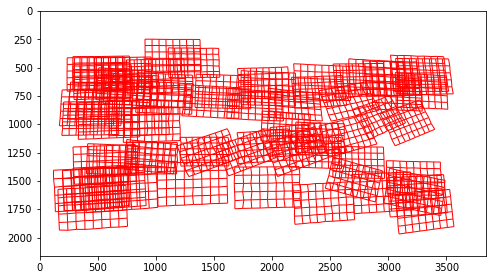

In [4]:
scene = app.plot_points_fisheye_undistort(
    points_fpath="points.json", 
    camera_fpath="camera_c.json"
)

## Undistort Images

Using the found intrinsic parameters and fisheye.undistortImage, return a 'corrected' undistored image.

### Distorted

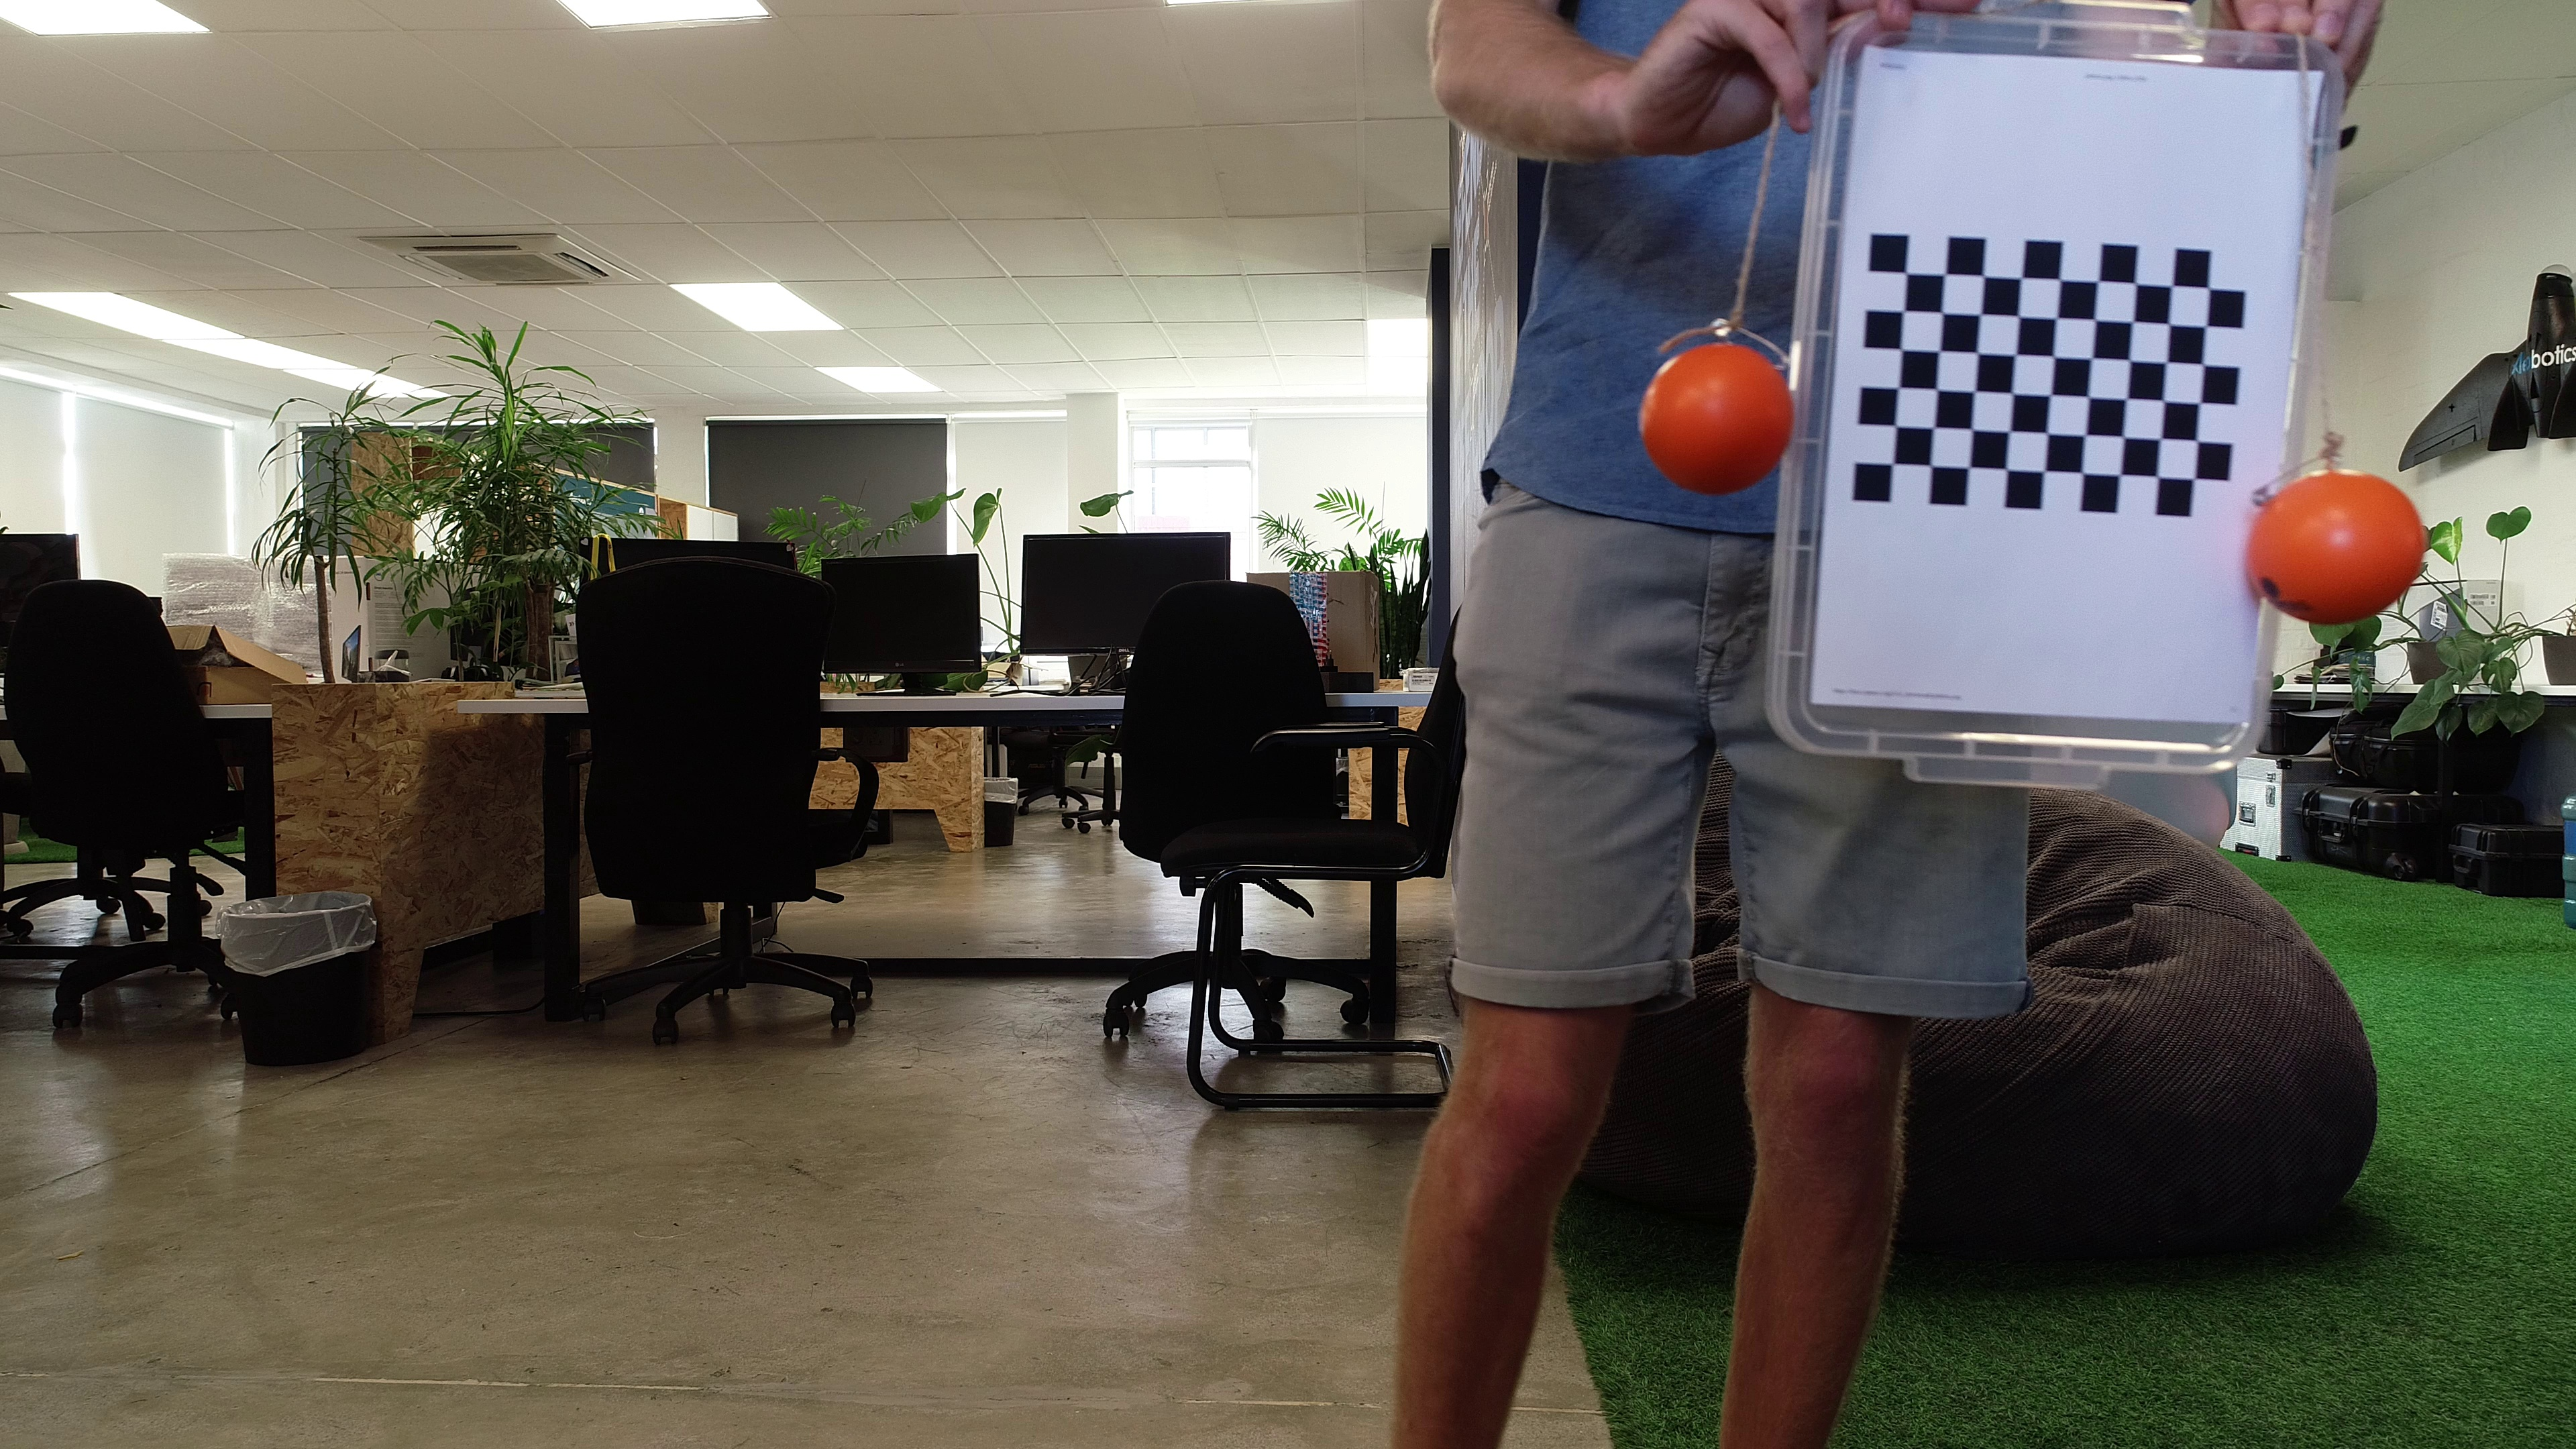

In [3]:
# Comparison image
from IPython.display import Image
Image(filename='./Test_Frames/img00570.jpg')

### Undistorted

The undistortion function effectively tries to remap the image given the now known intrinsic parameters.
It takes in the following:
1. The distorted image in the form of an array,
2. The intrinsic parameters K and D,
3. Knew which according to the documentation is also just the K matrix of the distorted image.

The result is an undistorted image array.

In [13]:
# Load intrinsics
k,d,resolution = utils.load_camera("camera_c.json")

# Img paths
image_fpath = './Test_Frames/img00570.jpg'
result_fpath = './Undistorted_imgs'

#Knew = k.copy()
#Knew[(0,1), (0,1)] = 1 * Knew[(0,1), (0,1)]

dist_img = cv2.imread(image_fpath)
result = cv2.fisheye.undistortImage(
    distorted=dist_img,
    K=k,
    D=d,
    Knew=k)
cv2.imwrite(os.path.join(result_fpath,"TEST_Img00570.jpg"),result)
#cv2.imshow("Undistoted", result)
#cv2.waitKey()

[[2.64718680e+03 0.00000000e+00 1.87852744e+03]
 [0.00000000e+00 2.66922761e+03 1.19526914e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[ 0.40498445]
 [ 0.30451978]
 [ 0.68970579]
 [-0.39927207]]


True

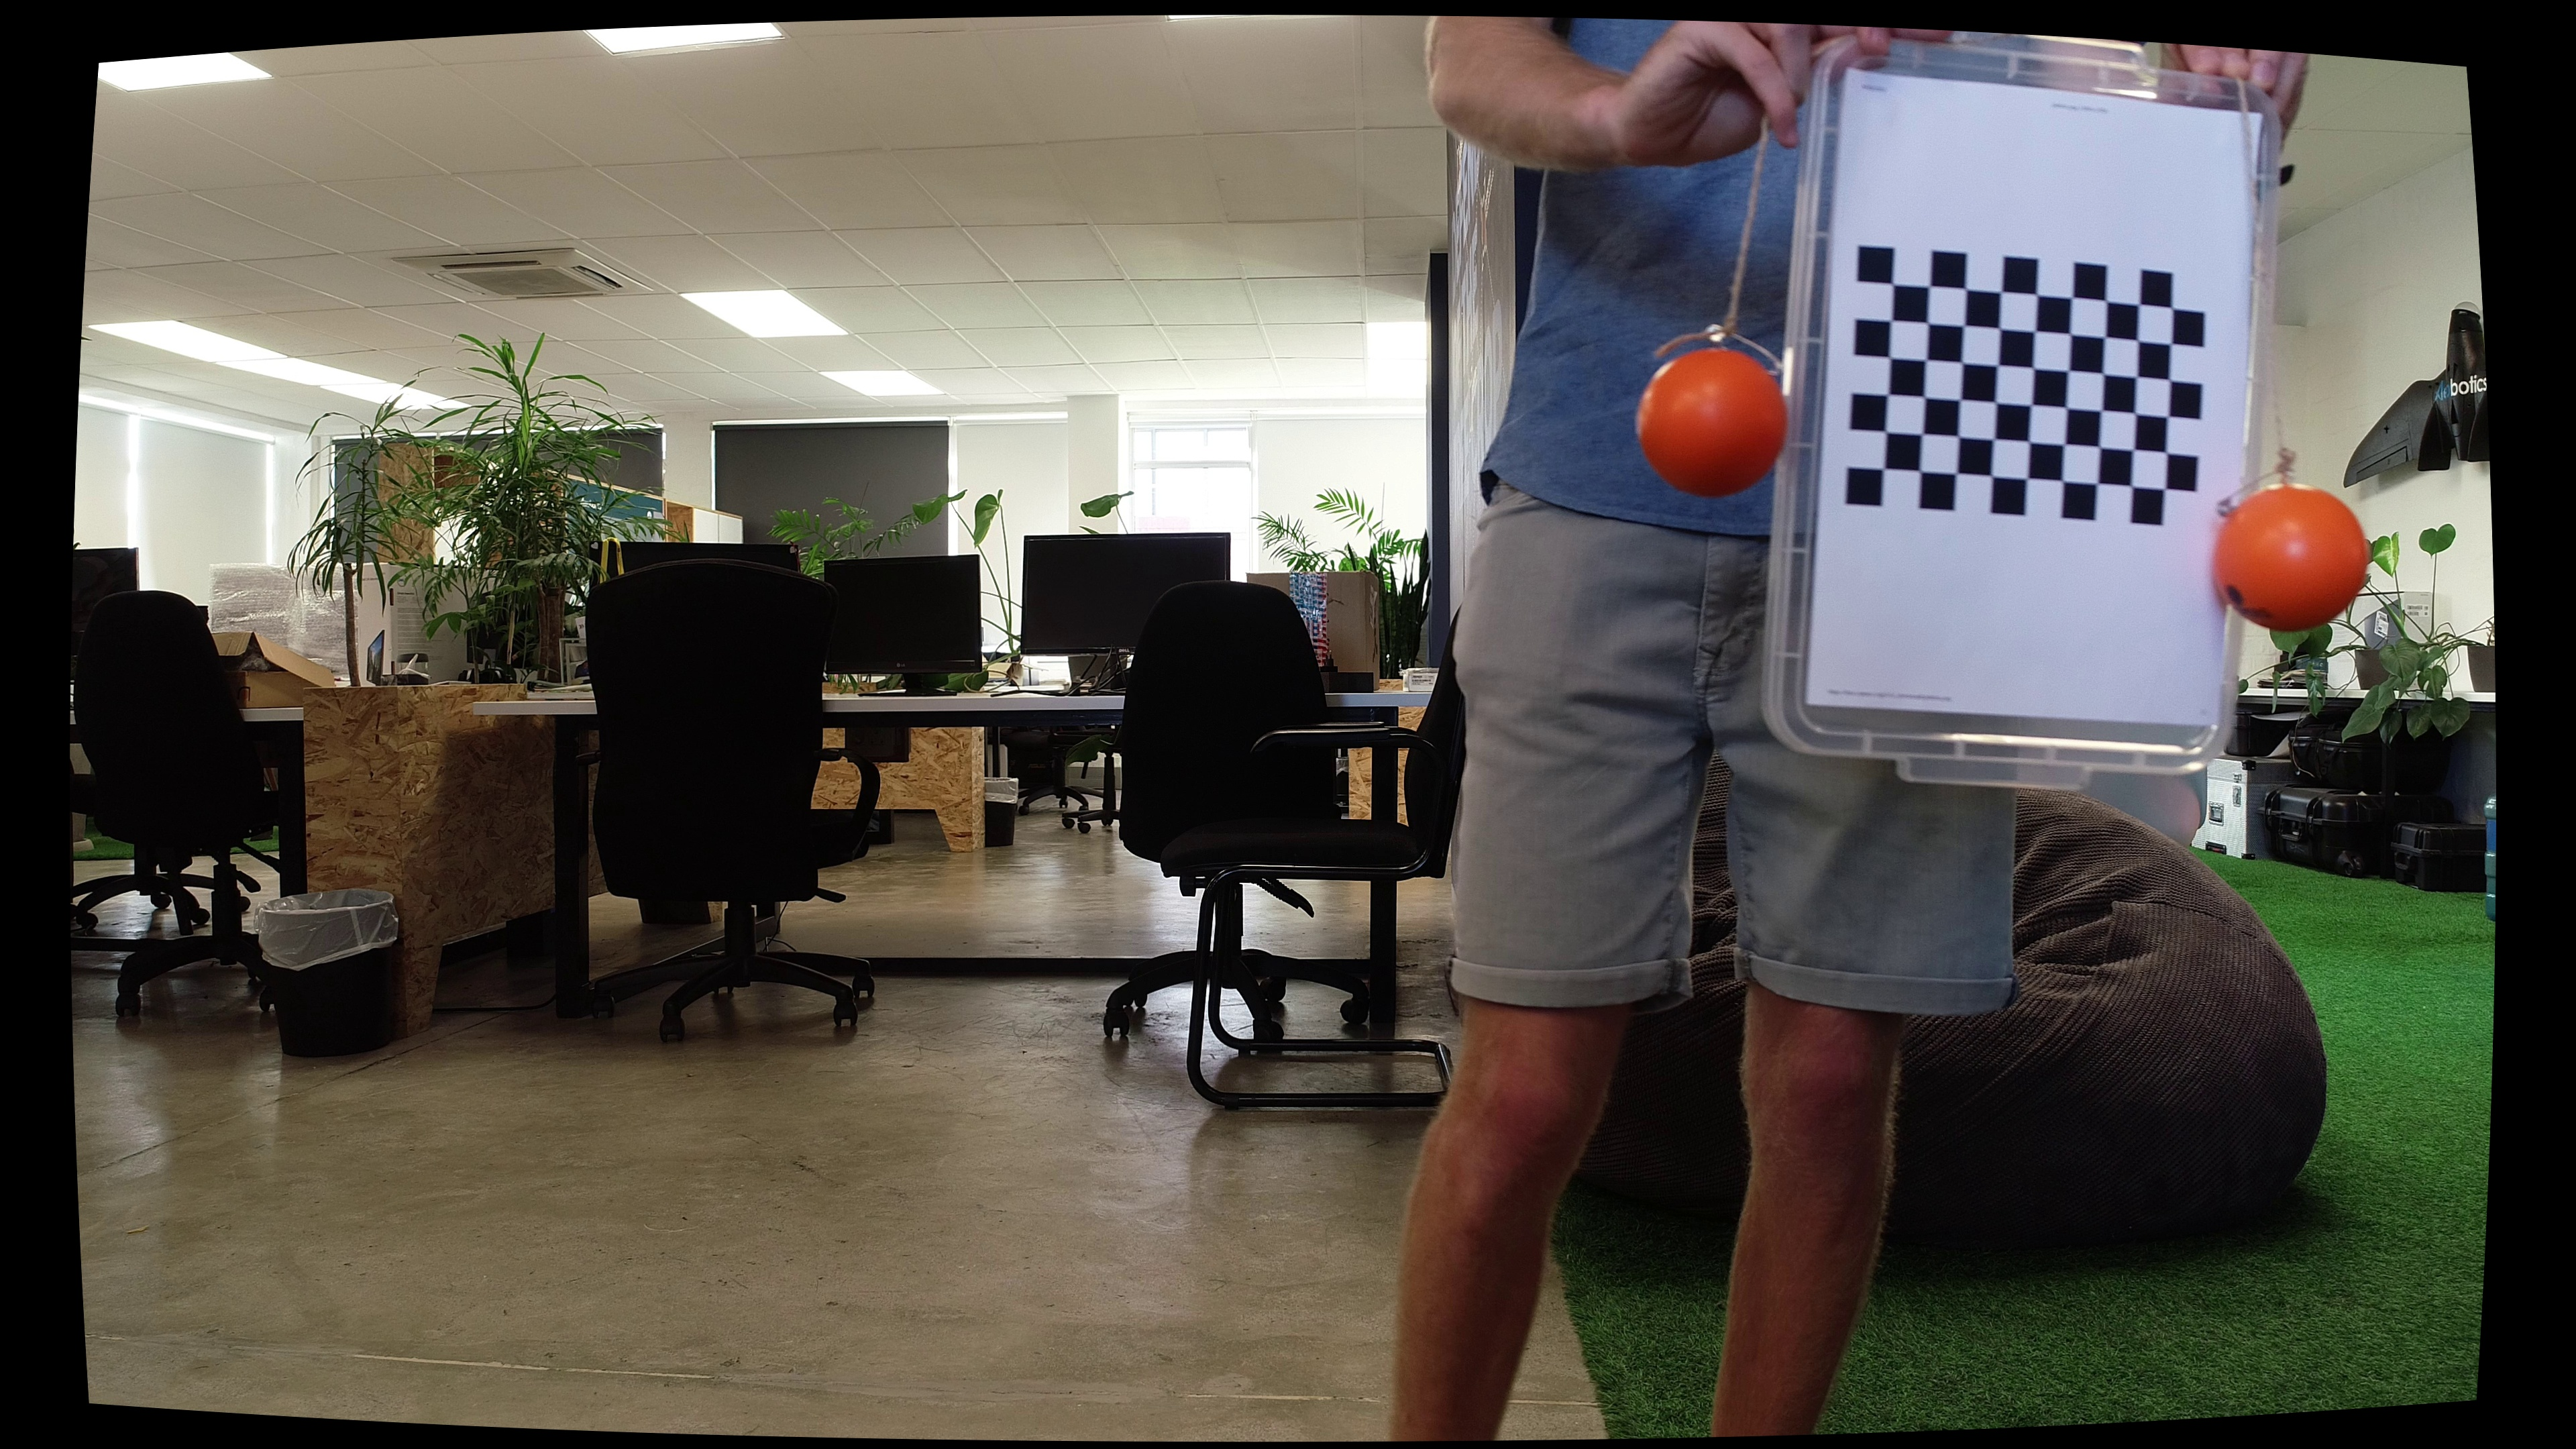

In [14]:
from IPython.display import Image
Image(filename=os.path.join(result_fpath,'TEST_Img00570.jpg'))